In [129]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


이미지 크기: (500, 892, 3)


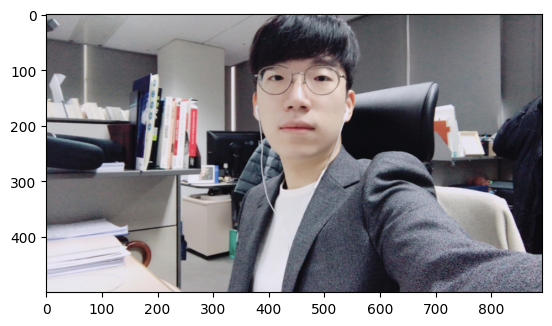

In [130]:
img_orig = cv2.imread("C:/Users/Choi/Desktop/my_image.png")
#img_orig = cv2.imread("C:/Users/Choi/Desktop/me.jpg")
print(f"이미지 크기: {img_orig.shape}")

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [131]:
model = deeplabv3_resnet101(pretrained=True).eval()

c:\Users\Choi\anaconda3\envs\aiffel\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Choi\anaconda3\envs\aiffel\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [132]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

#%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, 
(img_orig.shape[1], img_orig.shape[0]), 
interpolation=cv2.INTER_NEAREST)

In [133]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

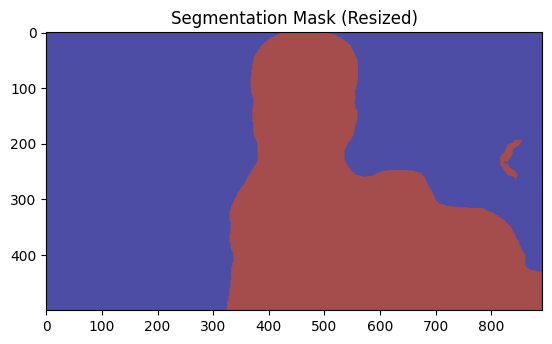

background
person


In [134]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

unique_classes = np.unique(output_predictions_resized)
unique_classes

for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

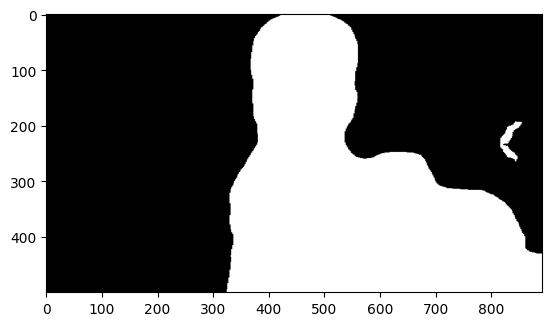

In [135]:
#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

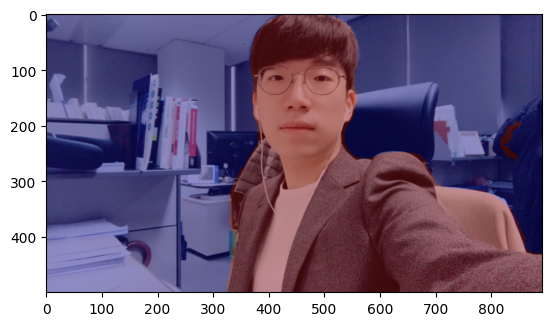

In [136]:
img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

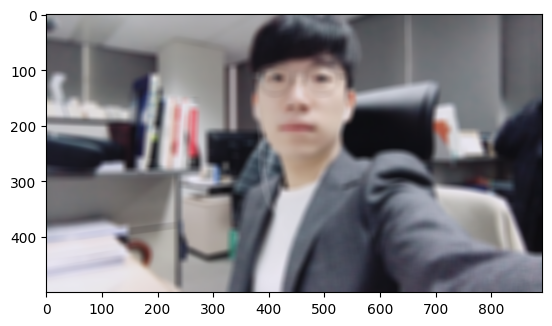

In [137]:

img_orig_blur = cv2.blur(img_orig, (13, 13))


plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

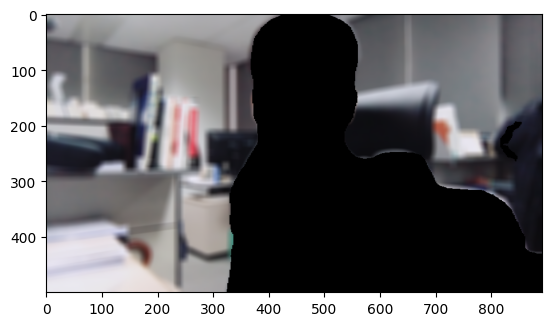

In [138]:

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

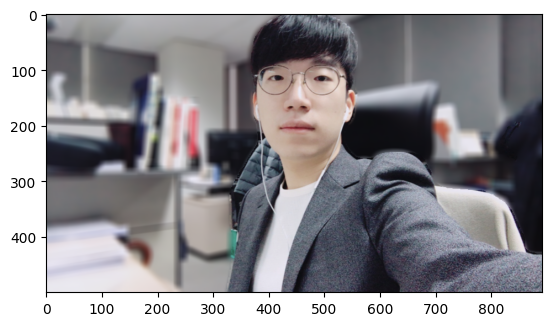

In [139]:

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


원본 고양이 이미지 크기: (1080, 1920, 3)
배경(사막) 이미지 크기: (1200, 1920, 3)


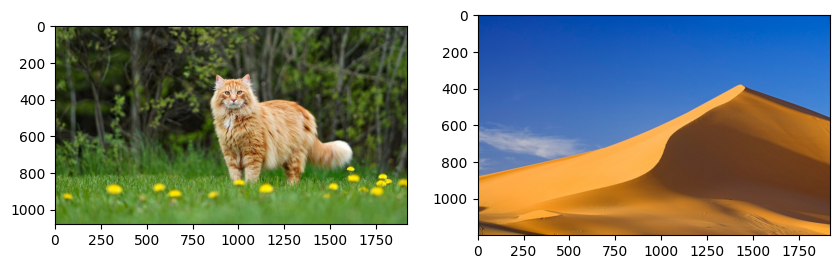

In [140]:
cat_img_path = "C:/Users/Choi/Desktop/cat1.jpg"  # 고양이 이미지를 준비해주세요
sand_img_path = "C:/Users/Choi/Desktop/Desert.jpg"  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [141]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [142]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

추론 마스크 크기 (After Resize): (1080, 1920)
예측된 클래스 ID: [0 8]


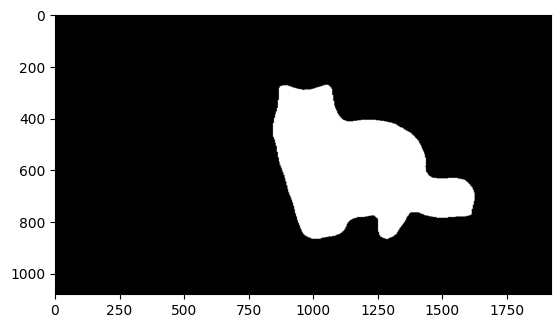

In [143]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

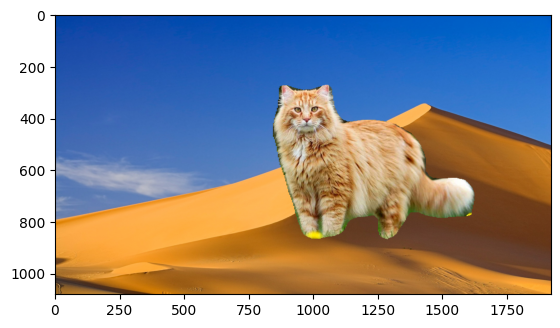

In [144]:

sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))


img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

# **진행한 인물사진의 문제점**

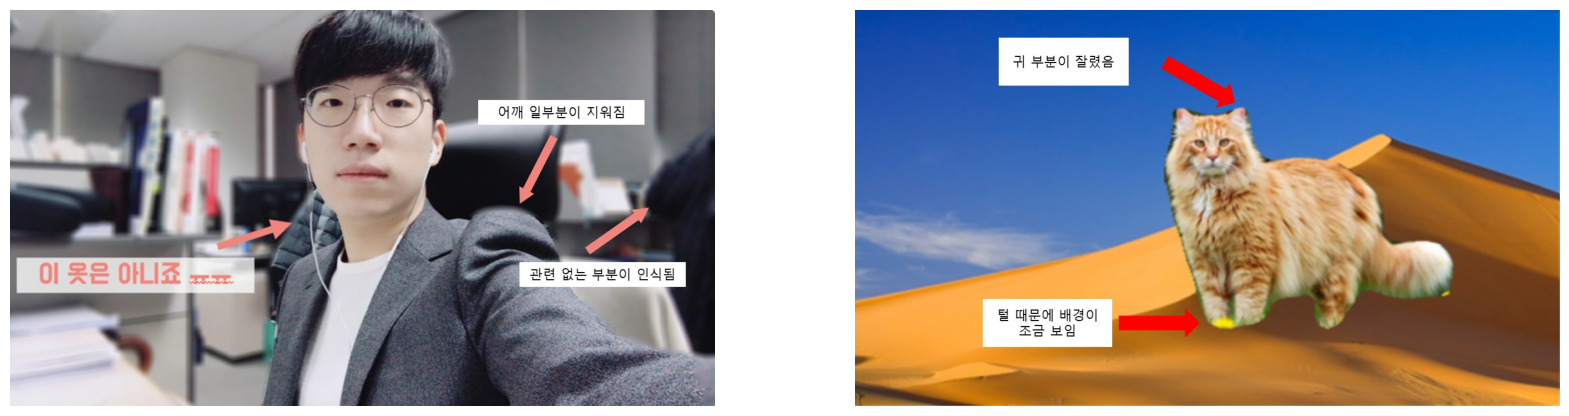

In [152]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread("C:/Users/Choi/Desktop/pro1.jpg"), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cv2.imread("C:/Users/Choi/Desktop/pro2.jpg"), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 솔루션

기존의 Sementic Segmentation은 마스크가 이진적이고 경계가 부정확하다는 문제가 있다. 
이를 해결하기위해서 2D 영역 분할 대신 3D 심도 정보를 활용하는 DPT(Dense Prediction Transformer)를 제안한다.
Vision Transformer 기술을 기반으로 기존 CNN 모델보다 이미지 전체의 광역적인 관계를 파악해 정밀하게 맵을 생성한다.

ViT를 인코더 백본으로 사용하여 이미지 전체의 광역정보를 처리하고 컨볼루션 디코더와 결합해 고해상도의 밀집 예측을 한다.

DPT가 생성한 Depth Map을 사용해 모든 픽셀의 거리를 확보한다.
-> 0과 1로만 구분되던 이진 마스크 블러 영역을 3D 거리 기준으로 결정한다.
Depth에 비례하는 강도 맵을 배경에 적용하여 블러를 구현한다.
-> 실제 렌즈의 DoF 원리를 모방하여 입체적이고 현실적인 아웃포커싱을 구현한다.

